<a href="https://colab.research.google.com/github/lovnishverma/Python-Getting-Started/blob/main/dogs_vs_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Dog Vs Cat CNN Classifier***

**Kaggle Dataset Link:** https://www.kaggle.com/datasets/princelv84/dogsvscats

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("princelv84/dogsvscats")

print("Path to dataset files:", path)

100%|██████████| 545M/545M [00:06<00:00, 88.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/princelv84/dogsvscats/versions/1


In [36]:
!ls /root/.cache/kagglehub/datasets/princelv84/dogsvscats/versions/1/train

cats  dogs


In [ ]:
# Import Required Libraries
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
# Setup and Configuration
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

In [ ]:
# Set seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# Define paths and constants
INPUT_DIR = '/root/.cache/kagglehub/datasets/princelv84/dogsvscats/versions/1/train'     # Source dataset directory
WORK_DIR = '/content'                       # Working directory
SAMPLE_DIR = os.path.join(WORK_DIR, 'sample')      # Path to hold sampled subset
IMG_HEIGHT, IMG_WIDTH = 150, 150                   # Image size to resize to
BATCH_SIZE = 32                                    # Batch size for data generators
EPOCHS = 20                                        # Number of training epochs

In [ ]:
# Prepare a Small Sample Dataset
def prepare_data(src, size=2000):
    """
    Prepare a subset of data with balanced classes for training and validation.
    - 1600 images for training (800 cats, 800 dogs)
    - 400 images for validation (200 cats, 200 dogs)
    """
    folders = ['train/cats', 'train/dogs', 'validation/cats', 'validation/dogs']
    for folder in folders:
        os.makedirs(os.path.join(SAMPLE_DIR, folder), exist_ok=True)

    # List and shuffle filenames
    cats = os.listdir(os.path.join(src, 'cats'))
    dogs = os.listdir(os.path.join(src, 'dogs'))
    random.shuffle(cats)
    random.shuffle(dogs)

    train_n, val_n = int(size * 0.4), int(size * 0.1)

    # Copy training images
    for i in range(train_n):
        shutil.copy(os.path.join(src, 'cats', cats[i]), os.path.join(SAMPLE_DIR, 'train/cats'))
        shutil.copy(os.path.join(src, 'dogs', dogs[i]), os.path.join(SAMPLE_DIR, 'train/dogs'))

    # Copy validation images
    for i in range(val_n):
        shutil.copy(os.path.join(src, 'cats', cats[train_n+i]), os.path.join(SAMPLE_DIR, 'validation/cats'))
        shutil.copy(os.path.join(src, 'dogs', dogs[train_n+i]), os.path.join(SAMPLE_DIR, 'validation/dogs'))

# Prepare the sample dataset
prepare_data(INPUT_DIR)

# Data Generators with Augmentation

# For training: use data augmentation to improve generalization
train_aug = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values
    rotation_range=20,          # Random rotation
    zoom_range=0.15,            # Random zoom
    width_shift_range=0.1,      # Horizontal shift
    height_shift_range=0.1,     # Vertical shift
    shear_range=0.15,           # Shear transformation
    horizontal_flip=True        # Random horizontal flip
)

# For validation: only normalize, no augmentation
val_aug = ImageDataGenerator(rescale=1./255)

# Load training data from directories
train_gen = train_aug.flow_from_directory(
    os.path.join(SAMPLE_DIR, 'train'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Load validation data from directories
val_gen = val_aug.flow_from_directory(
    os.path.join(SAMPLE_DIR, 'validation'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False   # Important for evaluation and predictions
)

In [ ]:
# Build the CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification (cat vs dog)
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),  # Stop early if no improvement
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-4) # Reduce learning rate on plateau
]

# Train the Model
history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=val_gen.samples // BATCH_SIZE,
    callbacks=callbacks
)

In [23]:
# Plot Accuracy and Loss Curves
def plot_history(hist):
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['accuracy'], label='Train')
    plt.plot(hist.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'], label='Train')
    plt.plot(hist.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

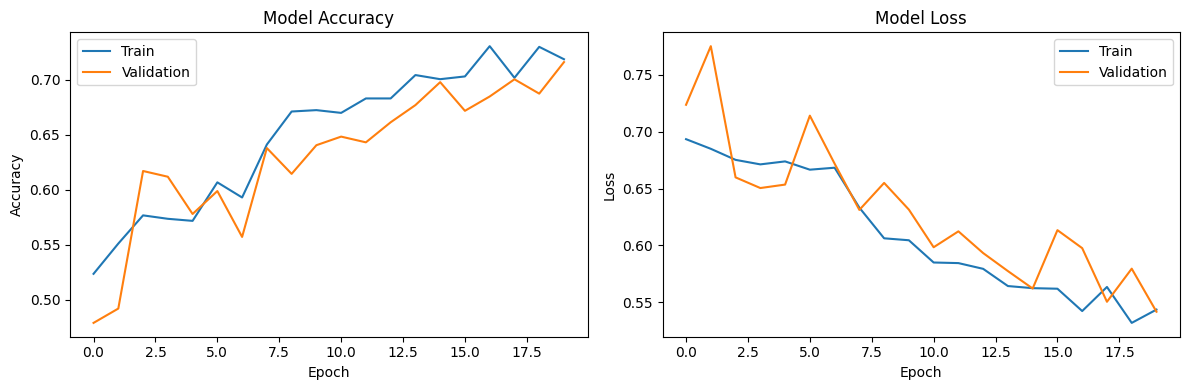

In [24]:
# Call the plotting function
plot_history(history)

In [25]:
# Final Evaluation on Validation Data
val_loss, val_acc = model.evaluate(val_gen, verbose=0)
print(f"Validation Accuracy: {val_acc:.4f}, Loss: {val_loss:.4f}")

Validation Accuracy: 0.7250, Loss: 0.5365


In [26]:
# Classification Report
val_gen.reset()  # Ensure ordering is preserved
preds = (model.predict(val_gen) > 0.5).astype(int).flatten()
y_true = val_gen.classes

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


In [27]:
# Print precision, recall, f1-score
print(classification_report(y_true, preds, target_names=['Cat', 'Dog']))

              precision    recall  f1-score   support

         Cat       0.75      0.67      0.71       200
         Dog       0.70      0.78      0.74       200

    accuracy                           0.72       400
   macro avg       0.73      0.73      0.72       400
weighted avg       0.73      0.72      0.72       400



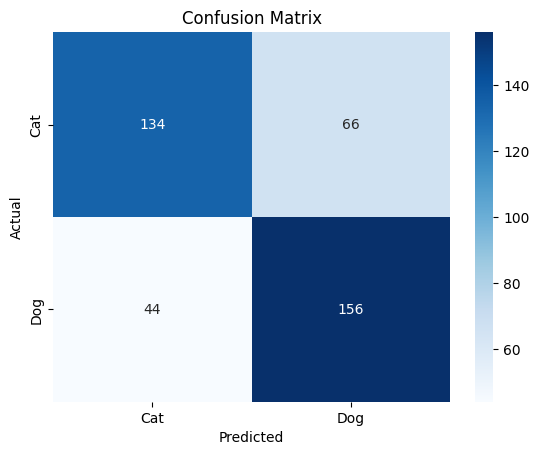

In [28]:
# Confusion Matrix
cm = confusion_matrix(y_true, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [29]:
# Save the Model (Legacy way- not recommended)
# model.save(os.path.join(WORK_DIR, 'dogs_vs_cats_model.h5'))

# Save Model in new Keras format (recommended)
final_model_path = os.path.join(WORK_DIR, 'dogs_vs_cats_model.keras')
model.save(final_model_path)
print("Final model saved at:", final_model_path)

Final model saved at: /content/dogs_vs_cats_model.keras


In [31]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the saved model (Legacy way- not recommended)
# model = load_model('/kaggle/working/dogs_vs_cats_model.h5')

# Load Model
loaded_model = tf.keras.models.load_model(final_model_path)
print("Loaded model, re-evaluating...")
loss, acc = loaded_model.evaluate(val_gen, verbose=0)
print(f"Reloaded model Accuracy: {acc:.4f}")

model = loaded_model

# Constants
IMG_HEIGHT = 150
IMG_WIDTH = 150

Loaded model, re-evaluating...
Reloaded model Accuracy: 0.7250


In [32]:
# Function to predict a single image
def predict_image(img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize

    # Prediction
    prediction = model.predict(img_array, verbose=0)
    confidence = prediction[0][0]

    # Display the image with prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {'Dog' if confidence > 0.5 else 'Cat'}\nConfidence: {confidence:.2f}" if confidence > 0.5 else f"Prediction: Cat\nConfidence: {1 - confidence:.2f}")
    plt.show()

    return "Dog" if confidence > 0.5 else "Cat"

In [37]:
!ls /root/.cache/kagglehub/datasets/princelv84/dogsvscats/versions/1/test

cats  dogs


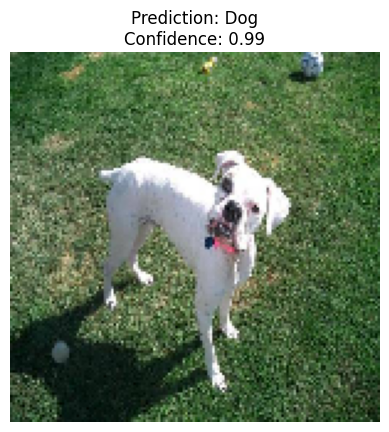

Predicted class: Dog


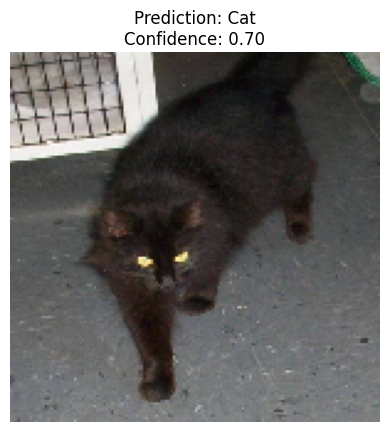

Predicted class: Cat


In [45]:
result = predict_image("/root/.cache/kagglehub/datasets/princelv84/dogsvscats/versions/1/test/dogs/dog.10028.jpg")
print("Predicted class:", result)


result = predict_image("/root/.cache/kagglehub/datasets/princelv84/dogsvscats/versions/1/test/cats/cat.2837.jpg")
print("Predicted class:", result)